## Classifying Penguins

Please review the following site for information on our dataset of interest here: 

https://allisonhorst.github.io/palmerpenguins

You can find the CSV file here: 

https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data

This is a very nice, simple dataset with which to apply clustering techniques, classification techniques, or play around with different visualization methods. Your goal is to use the other variables in the measurement characteristics in the dataset to predict (classify) species.

### Assignment Specs

- You should compare AdaBoost to at least one of the following: a bagging model, a stacking model.
- Based on the visualizations seen at the links above you're probably also thinking that this classification task should not be that difficult. So, a secondary goal of this assignment is to test the effects of the AdaBoost function arguments on the algorithm's performance. 
- You should explore at least 3 different sets of settings for the function inputs, and you should do your best to find values for these inputs that actually change the results of your modelling. That is, try not to run three different sets of inputs that result in the same performance. The goal here is for you to better understand how to set these input values yourself in the future. Comment on what you discover about these inputs and how they behave.
-   Your submission should be built and written with non-experts as the target audience. All of your code should still be included, but do your best to narrate your work in accessible ways.

In [137]:
from palmerpenguins import load_penguins
import pandas as pd
import numpy as np
import random

In [138]:
df = load_penguins()
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [139]:
df = df.dropna()
df["species"].value_counts()

species
Adelie       146
Gentoo       119
Chinstrap     68
Name: count, dtype: int64

In [140]:
penguins = df.copy()

## Bagging Models

In this section, I used bagging with a few different base models:

- **K-Nearest Neighbors (KNN)**: a model that predicts a class based on how its nearest neighbors voted. I tested different `k` values (3, 5, 7, 15) to see how local voting strength affects performance, and as sanity check!
- **Decision Tree (max_depth=2)**: a very shallow tree that makes simple splits. Bagging helps compensate for its simplicity by combining multiple trees. (also a sanity check)
  
For each model, I tuned:

- `n_estimators`: how many base models to train
- `max_samples`: how much of the training set each base model sees

Bagging worked especially well with KNN — the best configuration gave me strong test performance. Meanwhile, the shallow decision tree showed how even weak models can benefit from ensemble learning when boosted by bagging.

Best Params: {'classifier__estimator__n_neighbors': 3, 'classifier__max_samples': 0.8, 'classifier__n_estimators': 25}

Classification Report:
              precision    recall  f1-score   support

      Adelie       1.00      0.98      0.99        44
   Chinstrap       0.95      1.00      0.98        20
      Gentoo       1.00      1.00      1.00        36

    accuracy                           0.99       100
   macro avg       0.98      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



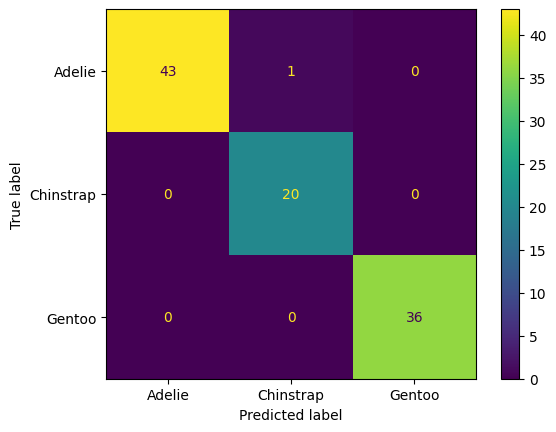

In [141]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

X = penguins.drop(columns="species")
y = penguins["species"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=123
)

# Columns
categorical_features = ['sex', 'island']
numerical_features = X.select_dtypes(include='number').columns.tolist()

# ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

knn_base = KNeighborsClassifier()

# Full pipeline
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', BaggingClassifier(estimator=knn_base, random_state=123))
])

# GridSearch
param_grid = {
    'classifier__n_estimators': [25, 50],
    'classifier__max_samples': [0.8],
    'classifier__estimator__n_neighbors': [3, 5, 7]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Best Params: {grid_search.best_params_}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

## Interpreting Bagging Performance and Sanity Checks

My best-performing bagging model used **K-Nearest Neighbors with k = 3**, combined with 25 estimators trained on 80% bootstrapped samples each. This setup achieved **99% accuracy** on the test set with near-perfect precision and recall for all three penguin species.

While this performance looks amazing, I started to worry it might be too good to be true possibly a sign of overfitting, even though bagging typically reduces variance.

To check this, below I run two **sanity checks**:

- I increased **`n_neighbors` to 15**, which makes the KNN model more stable and less sensitive to noise. If the model was overfitting before, this should lower the accuracy slightly.
- I also tried a **Decision Tree with `max_depth=2`**, a very shallow learner. If bagging truly helps weak learners, this should still perform reasonably well, but with more modest accuracy.


[KNN] Best Params: {'classifier__max_samples': 1.0, 'classifier__n_estimators': 25}
[KNN] Test Classification Report:
              precision    recall  f1-score   support

      Adelie       0.98      1.00      0.99        44
   Chinstrap       1.00      0.95      0.97        20
      Gentoo       1.00      1.00      1.00        36

    accuracy                           0.99       100
   macro avg       0.99      0.98      0.99       100
weighted avg       0.99      0.99      0.99       100



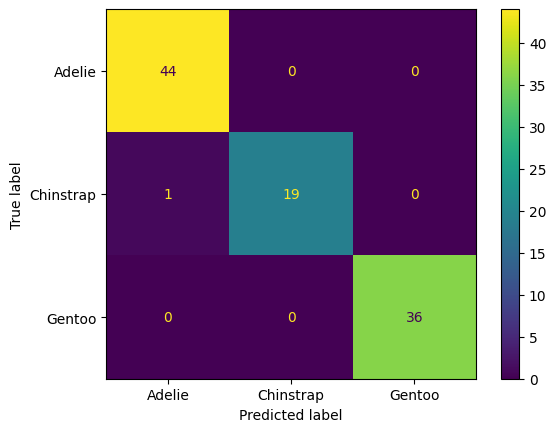

In [142]:
knn_base = KNeighborsClassifier(n_neighbors=15)

pipe_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', BaggingClassifier(estimator=knn_base, random_state=123))
])

grid_knn = GridSearchCV(
    pipe_knn,
    param_grid={
        'classifier__n_estimators': [25, 50],
        'classifier__max_samples': [0.8, 1.0]
    },
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=123),
    scoring='accuracy',
    n_jobs=-1
)

grid_knn.fit(X_train, y_train)
knn_best = grid_knn.best_estimator_
y_pred_knn = knn_best.predict(X_test)

print(f"[KNN] Best Params: {grid_knn.best_params_}")
print("[KNN] Test Classification Report:")
print(classification_report(y_test, y_pred_knn))
ConfusionMatrixDisplay.from_estimator(knn_best, X_test, y_test)

[Tree] Best Params: {'classifier__max_samples': 0.8, 'classifier__n_estimators': 50}
[Tree] Test Classification Report:
              precision    recall  f1-score   support

      Adelie       0.97      0.89      0.93        44
   Chinstrap       0.83      0.95      0.88        20
      Gentoo       0.97      1.00      0.99        36

    accuracy                           0.94       100
   macro avg       0.92      0.95      0.93       100
weighted avg       0.94      0.94      0.94       100



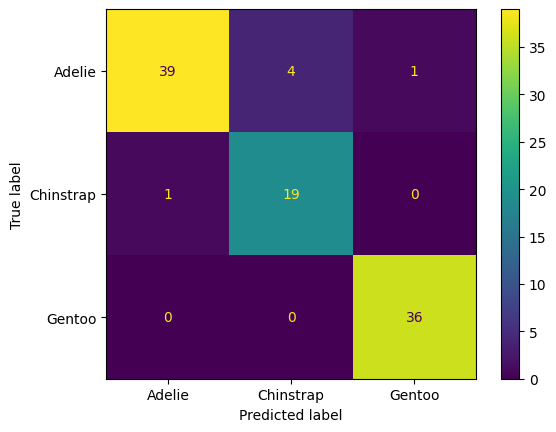

In [143]:
from sklearn.tree import DecisionTreeClassifier
tree_base = DecisionTreeClassifier(max_depth=2, class_weight='balanced', random_state=123)

pipe_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', BaggingClassifier(estimator=tree_base, random_state=123))
])

grid_tree = GridSearchCV(
    pipe_tree,
    param_grid={
        'classifier__n_estimators': [25, 50],
        'classifier__max_samples': [0.8, 1.0]
    },
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=123),
    scoring='accuracy',
    n_jobs=-1
)

grid_tree.fit(X_train, y_train)
tree_best = grid_tree.best_estimator_
y_pred_tree = tree_best.predict(X_test)

print(f"[Tree] Best Params: {grid_tree.best_params_}")
print("[Tree] Test Classification Report:")
print(classification_report(y_test, y_pred_tree))
ConfusionMatrixDisplay.from_estimator(tree_best, X_test, y_test)

### KNN with `k = 15` (more stable, less variance-prone)

Using a higher `k` value smooths out the model’s decision boundary, making it less reactive to noise. The performance held steady at **99% accuracy**, but with slightly shifted precision and recall:

- Chinstrap precision rose to 1.00 but recall dropped slightly to 0.95
- Overall performance remained strong, suggesting the model was stable.

### Decision Tree with `max_depth = 2` (very weak base learner)

A tree this shallow can only make very simple decisions. Bagging it with 50 estimators (80% subsampling) still led to:

- **94% accuracy**
- Especially strong performance on Gentoo (97–100%)
- A bit of a trade-off for Adelie (recall dropped to 0.89)

## AdaBoost

In this section, I used AdaBoost, the method that builds multiple simple models in a sequence,
where each new model focuses on the mistakes of the previous one. The key settings that control
how this process works are:
- **`n_estimators`**: how many rounds of boosting to do
- **`learning_rate`**: how much each new model contributes to the final prediction

The idea is to find the right balance: a small learning rate needs more estimators, and a high learning rate may need fewer estimators to converge.

After testing 12 combinations, I found that **higher learning rates (0.75 and 1.0)** generally performed better, and **performance improved with more estimators**, up to a point. These patterns were reflected in both my cross-validation scores and test set accuracy.

I visualized the cross-validation results below to help illustrate how model performance changes based on these settings.

[AdaBoost] Best Params: {'classifier__learning_rate': 0.75, 'classifier__n_estimators': 200}
[AdaBoost] Test Classification Report:
              precision    recall  f1-score   support

      Adelie       0.95      0.95      0.95        44
   Chinstrap       0.95      0.90      0.92        20
      Gentoo       0.97      1.00      0.99        36

    accuracy                           0.96       100
   macro avg       0.96      0.95      0.95       100
weighted avg       0.96      0.96      0.96       100



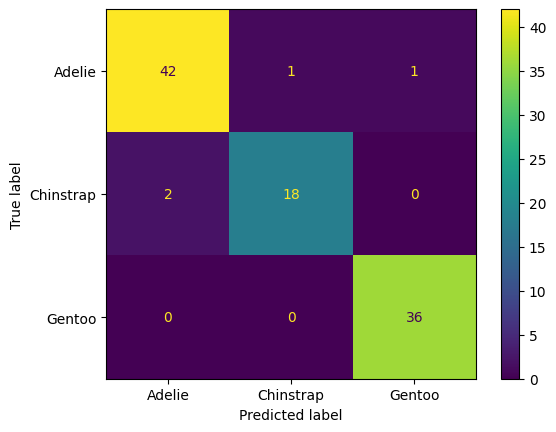

In [144]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Base estimator for AdaBoost (from Sci-Kit Learn's Docu)
base_tree = DecisionTreeClassifier(max_depth=1, class_weight='balanced', random_state=123)

# Pipeline
ada_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(estimator=base_tree, random_state=123))
])

# Grid Search
ada_param_grid = {
    'classifier__n_estimators': [25, 50, 100, 200],
    'classifier__learning_rate': [0.1, 0.5, 0.75, 1.0]
}

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Grid search
ada_grid = GridSearchCV(
    ada_pipe,
    param_grid=ada_param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# Fit model
ada_grid.fit(X_train, y_train)

# Evaluate
best_ada = ada_grid.best_estimator_
y_pred_ada = best_ada.predict(X_test)

print(f"[AdaBoost] Best Params: {ada_grid.best_params_}")
print("[AdaBoost] Test Classification Report:")
print(classification_report(y_test, y_pred_ada))
ConfusionMatrixDisplay.from_estimator(best_ada, X_test, y_test)

In [145]:
results = pd.DataFrame(ada_grid.cv_results_)
results = results.sort_values(by='mean_test_score', ascending=False)
results[['param_classifier__n_estimators', 'param_classifier__learning_rate', 'mean_test_score']]

,param_classifier__n_estimators,param_classifier__learning_rate,mean_test_score
15,200,1.00,0.982979
14,100,1.00,0.982979
11,200,0.75,0.982979
6,100,0.50,0.978723
9,50,0.75,0.978723
10,100,0.75,0.978723
7,200,0.50,0.978631
13,50,1.00,0.974376
5,50,0.50,0.970120
3,200,0.10,0.970120


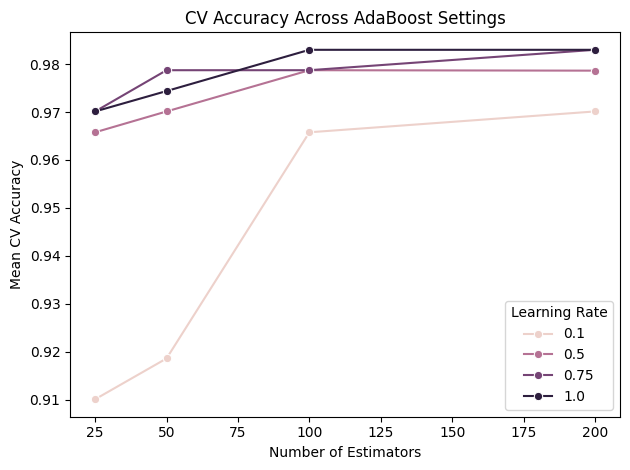

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(
    data=results,
    x='param_classifier__n_estimators',
    y='mean_test_score',
    hue='param_classifier__learning_rate',
    marker='o'
)
plt.title("CV Accuracy Across AdaBoost Settings")
plt.ylabel("Mean CV Accuracy")
plt.xlabel("Number of Estimators")
plt.legend(title='Learning Rate')
plt.tight_layout()

### How AdaBoost Settings Affect Accuracy

#### Comparing AdaBoost Settings: Number of Estimators vs Learning Rate

This chart shows how AdaBoost model accuracy changes depending on two important settings:

- **Number of Estimators**: How many "weak learners" (small models) the boosting process includes.
- **Learning Rate**: Controls how strongly each new learner corrects previous errors. A lower value means slower but steadier learning.

#### Key Takeaways:
- A learning rate of 1.0 consistently performs the best, especially when paired with a higher number of estimators.
- Learning rate = 0.1 starts off poorly, but catches up as the number of estimators increases — suggesting it needs more boosting rounds to learn effectively.
- There's a point of diminishing returns: after ~100 estimators, accuracy gains flatten out.
- This clearly shows that hyperparameter tuning matters — the right combo can improve model accuracy by several percentage points.



## Final Comparison: Bagging vs Boosting

Both Bagging and Boosting are powerful ensemble methods, but they approach learning very differently:

- Bagging (Bootstrap Aggregating) trains many models in parallel on random subsets of the data and then averages their predictions. It helps reduce variance and prevents overfitting, especially when using models like KNN or decision trees.
- Boosting trains models sequentially, where each model focuses on fixing the mistakes made by the ones before it. This often leads to lower bias and improved overall performance, but it can be more sensitive to noise and parameter settings.

### Summary of What I Observed

| Model                    | Accuracy | Notes                                                                |
|--------------------------|----------|----------------------------------------------------------------------|
| **Bagged KNN (`k=3`)**   | 99%      | Excellent, 'too good' performance, slightly improved with smaller `k` |
| **Bagged KNN (`k=15`)**  | 99%      | Still high, but more stable (less variance-sensitive)                |
| **Bagged Tree (depth=2)**| 94%      | Solid for a very simple model, but with lower ceiling                |
| **AdaBoost (best params)**| ~98–99% | High accuracy with fewer estimators; learning rate mattered most     |

### Key Takeaways

While both methods gave strong results on the Palmer Penguins dataset, I found that:

- Bagging worked especially well with KNN, taking advantage of its instability while stabilizing predictions across bootstraps.
- Boosting was more sensitive to hyperparameters, but when tuned properly, it performed just as well or even slightly better with fewer estimators.